# 002: pixel-by-pixel phase mapping
Map peaks on a 2D pixel grid and find the best-matching phase for each pixel among a list of pre-defined crystal structures

### Load packages

In [24]:
# general modules
import os, sys, glob
import h5py
import pylab as pl
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from tqdm import tqdm

# ImageD11 https://github.com/FABLE-3DXRD/ImageD11
import ImageD11.sinograms.dataset
import ImageD11.columnfile
import ImageD11.parameters


# point-fit 3dxrd module available at https://github.com/jbjacob94/pf_3dxrd.
# Not yet installable with pip, just copy + paste the files into your working folder 
if '/home/esrf/jean1994b/' not in sys.path:
    sys.path.append('/home/esrf/jean1994b/')    

from pf_3dxrd import utils, friedel_pairs, pixelmap, crystal_structure, peak_mapping, phase_mapping

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data & crystal structures


In [25]:
def load_data(dsname, parfile):
    
    # paths
    pksfile = os.path.join(data_dir, dsname+'_pks_p.h5')
    dsfile  = pksfile.replace('pks_p','dataset')
    
    # load ds file and peak file
    ds = ImageD11.sinograms.dataset.load(dsfile)
    print(f'Loading data for dataset {ds.dsname}: \n==============================')    
    items = 'n_ystep,n_ostep,ymin,ymax,ystep,omin,omax,ostep'.split(',')
    vals  = [ds.shape[0], ds.shape[1], ds.ymin, ds.ymax, ds.ystep, ds.omin, ds.omax, ds.ostep]
    for i,j in zip(items, vals):
        print(f'{i}: {j:.2f}')
        
    print('==============================')
    
    
    cf = ImageD11.columnfile.columnfile(pksfile)
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    
    # update tth, etc. using Friedel pairs. 
    friedel_pairs.update_geometry_s3dxrd(cf, ds, update_gvecs=True)

    
    print('\n loaded peakfile: \nnrows =', cf.nrows)
    utils.get_colf_size(cf)
    
    return cf, ds


In [26]:
# paths
data_dir = 'data'
dsname = 'SI3_DT360Z5480'
parfile='data/SI3.par'

#data_dir = 'wg_data'
#dsname = 'WG102_2000um'
#parfile = 'wg_data/WG102.par'

In [27]:
# load data
cf, ds = load_data(dsname, parfile)

Loading data for dataset SI3_DT360Z5480: 
n_ystep: 109.00
n_ostep: 450.00
ymin: -2.70
ymax: 2.70
ystep: 0.05
omin: 0.00
omax: 360.00
ostep: 0.80
Reading your columnfile in hdf format

 loaded peakfile: 
nrows = 2870632
Total size =  251.87 MB


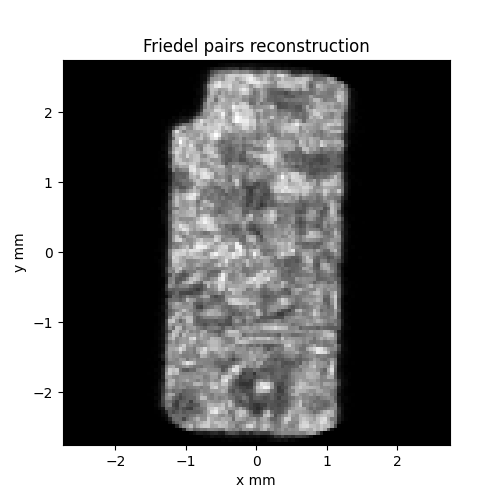

In [28]:
# plot sample reconstruction to check it is ok
kw = {'cmap':'Greys_r', 'vmin':0.01, 'vmax':0.9}
utils.friedel_recon(cf, ds.ybinedges, ds.ybinedges, norm=True, doplot=True, mask = None, **kw);

In [29]:
# load crystal structures and store them in a dictionnary
pnames = ['quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'] # cif files should be named '<phase_name>.cif'
phase_dict = {name: crystal_structure.load_CS_from_cif(cif_path = f'cif/{name}.cif', name=name, pid = i) for i,name in enumerate(pnames)}

for cs in phase_dict.values():
    print(cs)


CS: quartz, phase_id: 0, spg: P3221, spg_no: 154, lattice: [  4.91325   4.91325   5.41206  90.       90.      120.     ]
CS: magnetite, phase_id: 1, spg: Fd3m, spg_no: 227, lattice: [ 8.3965  8.3965  8.3965 90.     90.     90.    ]
CS: biotite, phase_id: 2, spg: C12/m1, spg_no: 12, lattice: [  5.355   9.251  10.246  90.    100.15   90.   ]
CS: orthoclase, phase_id: 3, spg: C1-11, spg_no: 12, lattice: [  8.589  13.013   7.197  90.    116.02   90.   ]
CS: oligoclase, phase_id: 4, spg: C-1, spg_no: 2, lattice: [  8.154  12.823   7.139  94.06  116.5    88.59 ]


### Initialize 2D map (pixelmap) and PhaseMapper object

In [30]:
# pixelmap: object to store and plot data on a 2D grid. Initialize from dataset
xmap = pixelmap.create_from_dataset(ds, h5name = os.path.join(data_dir, ds.dsname+'_xmap.h5') )
    
#pixelmap phases: add them from dict
for phasename, cs in phase_dict.items():
    xmap.phases.add_phase(phasename, cs)
    
print(xmap)

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id'], 
 grains: 0


In [31]:
# PhaseMapper object to map peaks to pixel and find best phase match on the 2D grid
PhaseMapper = phase_mapping.PhaseMapper(cf, ds, xmap, CS_list=phase_dict.values())

print('================= \n',PhaseMapper)

no xyi column in peakfile. Adding pixel index...
sorting by two-theta...
rescaling intensity...
 PhaseMapper:
 peaks to map:2870632
 phases: ['quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase']
 phase_ids:[0, 1, 2, 3, 4]
 grid: size: (110, 110), pixel size: 50.0 µm
 minpks: 50
 min_confidence: 0.1
 kernel_size: 1


### Compute raw phase masks
Add selection mask for each phases in PhaseMapper. Peak selection in each mask is based on a simple 2-theta threshold selection around pre-computed theoretical 2-theta positions of Bragg peaks. A peak can belong to multiple masks when Bragg peaks from different phases overlap. 


Scatter(quartz with 2 atomic positions, 6 symmetries)
       Type: x-ray
     Energy: 43.57356018082551 keV
 Wavelength: 0.28454050670689945 A
 ---Settings---
      Powder units: tth
    Isotropic ADPs: True
  Specular Direction (reflection): ( 0, 0, 1)
Parallel Direction (transmission): ( 0, 0, 1)
      theta offset: 0.0
         min theta: -180.0
         max theta: 180.0
      min twotheta: 0
      max twotheta: 15
 ---X-Ray Settings---
 Waasmaier scattering factor: False
 ---Magnetic Settings---
   Mag. scattering: True
  Mag. form factor: True
         Polarised: False
      Polarisation: sp
       Pol. vector: (0,1,0)
 ---Resonant Settings---
   Azimuthal angle: 0
    Azimuthal ref.: (1,0,0)
               flm: (0,1,0)
  use e1e1 approx.: True

Scatter(magnetite with 3 atomic positions, 192 symmetries)
       Type: x-ray
     Energy: 43.57356018082551 keV
 Wavelength: 0.28454050670689945 A
 ---Settings---
      Powder units: tth
    Isotropic ADPs: True
  Specular Direction (refl

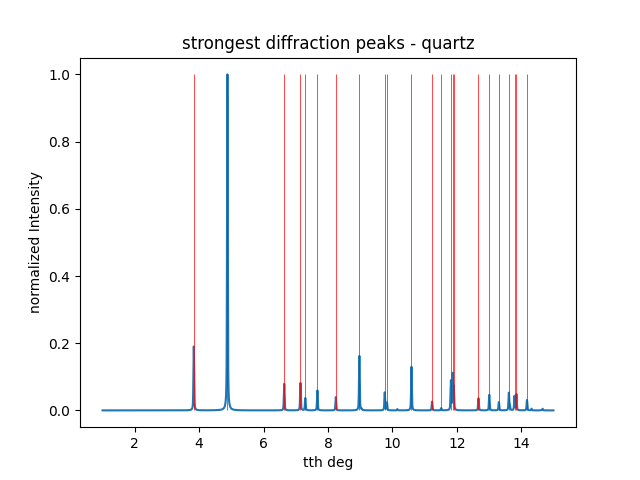

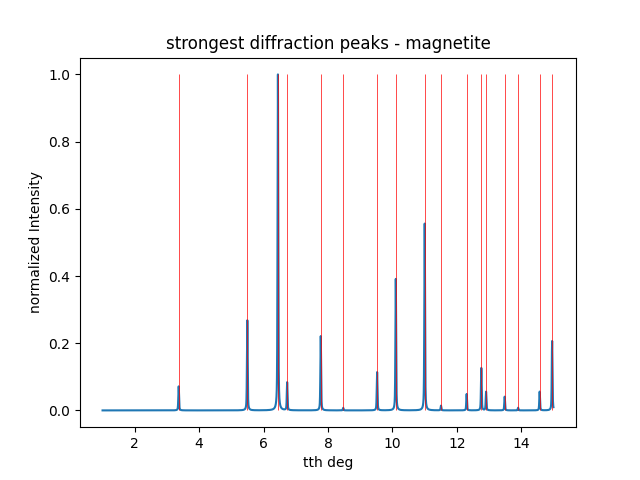

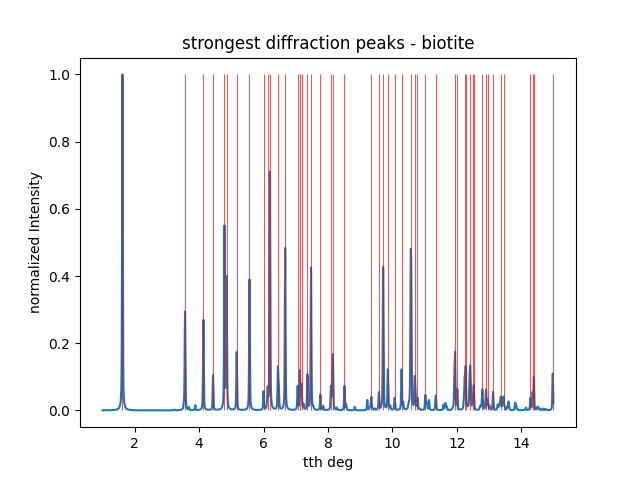

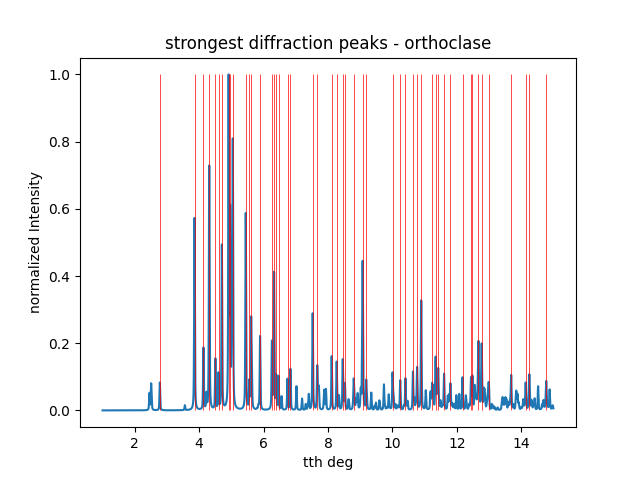

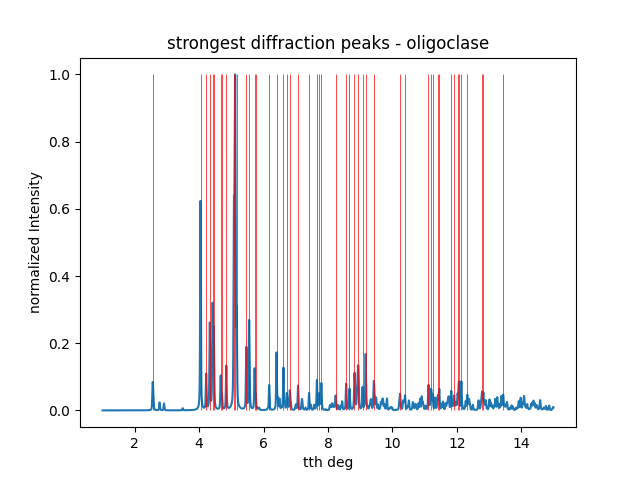

In [32]:
# first identify position of Bragg peaks. See Tuto_002 or docstrings for details
PhaseMapper.find_strongest_bragg_peaks_all(0, 15, Nmax=50, Imin=0.005, prominence=0.005, doplot=True) 

Compute phase masks. The proportion of peaks selected in each mask is returned, as well as the total fraction of peaks assigned (selected by at least one phase) and the fraction of peak overlaps (fraction of peaks assigned to more than one phase).

In [33]:
# compute phase masks
PhaseMapper.compute_phase_mask_all(tth_max=15, tth_tol=0.025)

pks fraction quartz: 0.2495
pks fraction magnetite: 0.0652
pks fraction biotite: 0.2284
pks fraction orthoclase: 0.2443
pks fraction oligoclase: 0.2633

Total pks fraction assigned: 0.6945
fraction overlapping: 0.2951


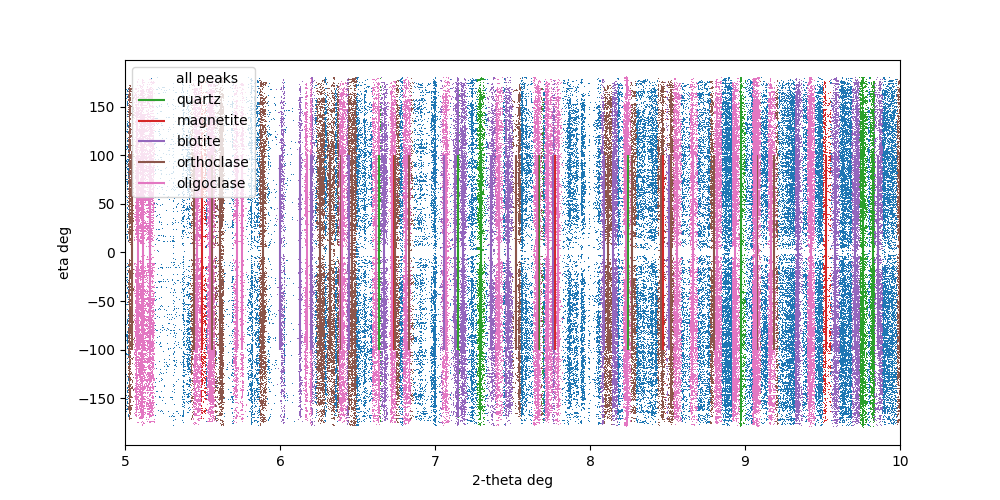

In [34]:
# plot tth vs eta for a subset of peaks to see what the selection looks like
PhaseMapper.plot_tth_eta(min_tth=5, max_tth=10, show_theorytth=True, phase_colors='from_mask')

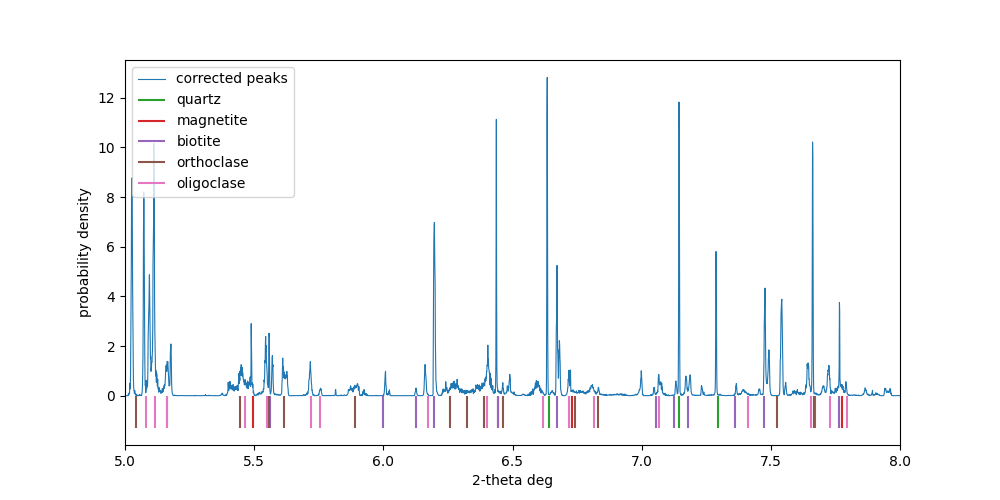

In [35]:
# can do it as well with a 2-theta histogram: less messy
PhaseMapper.plot_tth_histogram(min_tth=5, max_tth=8, tth_step=0.0005,
                               show_non_corrected=False, show_theorytth=True)

### Phase labeling

In [36]:
# run this function to set up PhaseMapper for phase labelling. This does a bunch of stuff, including sorting the peakfile and initializing some variables
PhaseMapper.prepare_for_phase_labeling()

Ready for phase labeling!


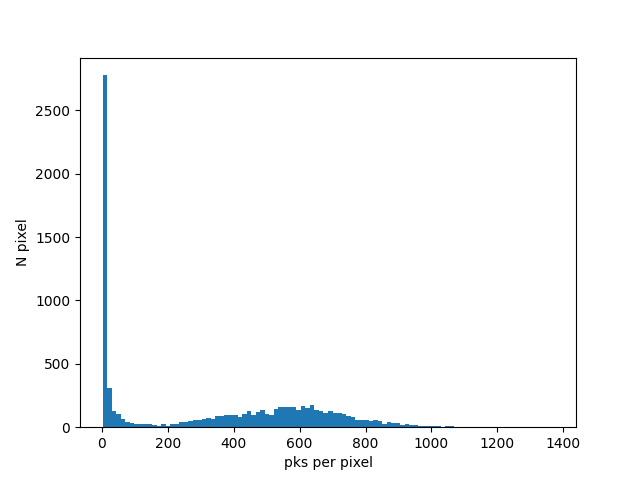

In [37]:
# plot the distribution of peak counts per pixel, to adjust the minpks parameter (below).
def npks_per_pixel_hist(cf):
    px, cnts = np.unique(cf.xyi, return_counts=True)
    pl.figure()
    pl.hist(cnts[cnts>0],100);
    pl.xlabel('pks per pixel')
    pl.ylabel('N pixel')
    
npks_per_pixel_hist(cf)
    


Set up parameters in PhaseMapper
- minpks : minimum number of peaks in a pixel, below which it will remained unlabeled
- min_confidence : lower threshold for normalized confidenc eindex, below which the pixel will remain unlabeled
- kernel_size : peak selection is done in a $n \times n$ kernel around each pixel. default is n=1 (signel pixel selection), but kernel size can be increased to get smoother map. If larger kernel size is used, think of increasing minpks accordingly
- chunksize : size of chunks for multiprocessing
- ncpu : number of cpus used for multiprocessing. Default is the largest number available
- res: dictionnary in which phase labelign outputs are temporarily written

In [38]:
PhaseMapper.kernel_size = 3
PhaseMapper.minpks = 800
PhaseMapper.min_confidence = 0.05
PhaseMapper.chunksize = 500
PhaseMapper.ncpu
PhaseMapper.res = {}

In [39]:
# run phase mapping in parallel

def func_wrapper(px):
    return px, PhaseMapper.best_phase_match(px)

if __name__ == "__main__":
    with ProcessPoolExecutor() as pool:
        pool.max_workers=max(PhaseMapper.ncpu-1,1)
        pool.mp_context=multiprocessing.get_context('fork')
        
        for px, r in tqdm( pool.map(func_wrapper,
                                PhaseMapper.xyi_uniq,
                                chunksize=PhaseMapper.chunksize) ):
            PhaseMapper.res[px] = r

8503it [00:03, 2268.56it/s]


In [40]:
# write outputs in pixelmap. peakfile phase_id column is also updated at the same time, giving a phase label to each peak
PhaseMapper.results_to_xmap()

100%|██████████| 8503/8503 [00:00<00:00, 987079.43it/s]

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Npks', 'phase_label_confidence', 'completeness', 'uniqueness'], 
 grains: 0


In [41]:
# print some stats about laleled peaks: fraction of peaks assigned to each phase (in proportion of the total number of peaks in peakfile)
PhaseMapper.get_stats_labeled_peaks()

fraction of labeled peaks 
----------
quartz: 0.1423
magnetite: 0.0051
biotite: 0.0668
orthoclase: 0.0564
oligoclase: 0.1130
assigned: 0.3836
fraction of total intensity 
----------
quartz: 0.2677
magnetite: 0.0211
biotite: 0.1172
orthoclase: 0.0692
oligoclase: 0.1518
assigned: 0.6271


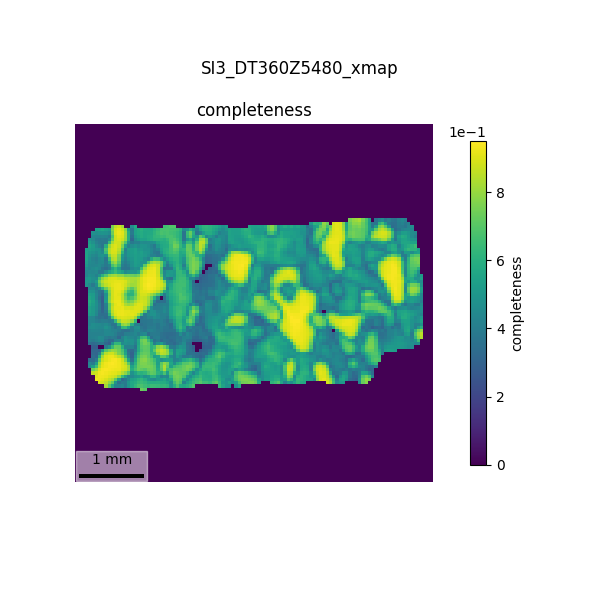

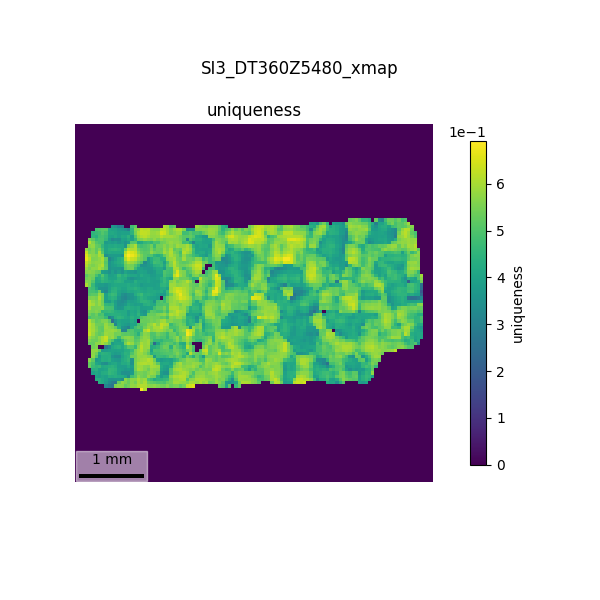

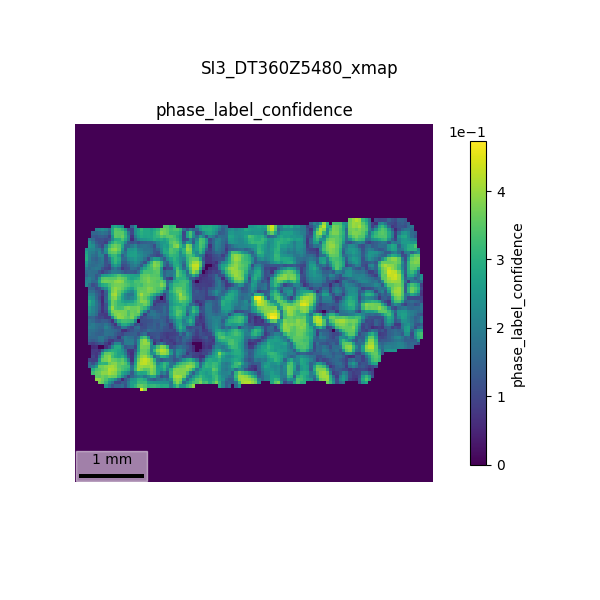

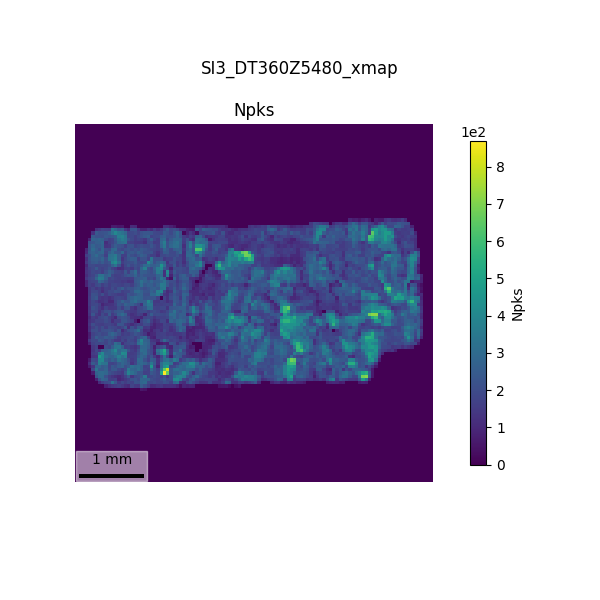

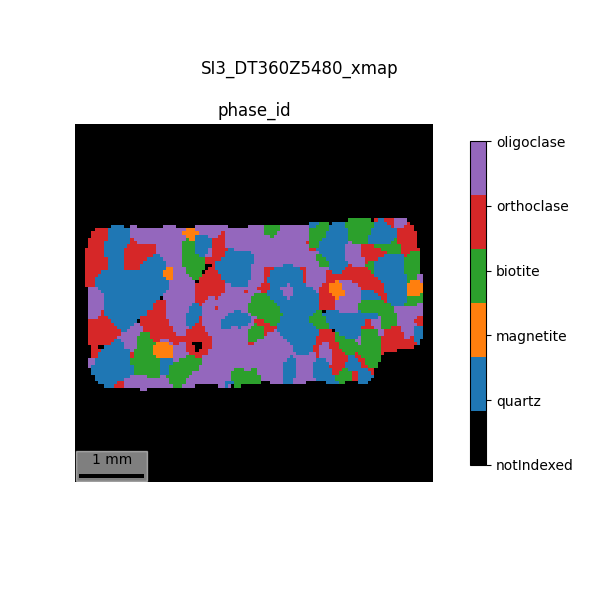

In [42]:
# make some plots and save : phase_id, Ci, Npks
pl.close('all')

colors = ((0,0,0),) + pl.matplotlib.cm.tab10.colors
cmap = pl.matplotlib.colors.ListedColormap( colors[:len(xmap.phases.pnames)] )

save=False
var_to_plot = ['completeness','uniqueness','phase_label_confidence','Npks','phase_id']


for i, var in enumerate(var_to_plot):
    if var == 'phase_id':
        kw = {'cmap':cmap}
        xmap.plot(var, autoscale=False, save=save, **kw)
        
    else:
        kw = {'cmap':'viridis'}
        xmap.plot(var, autoscale=False, percentile_cut=[1, 99], save=save, **kw)


### Filter peak file and save outputs

In [45]:
cc = cf.copy()

In [49]:
np.unique(cf.phase_id, return_counts=True)

(array([-1,  0,  1,  2,  3,  4]),
 array([1769376,  408580,   14732,  191642,  161932,  324370]))

In [46]:
# remove phase mask columns in peakfile. we don't need them anymore
columns_to_drop = PhaseMapper.phases.pnames+['overlap','assigned']

cf = ImageD11.columnfile.colfile_from_dict({t:cf.getcolumn(t) for t in cf.titles if t not in columns_to_drop})

In [52]:
cf.nrows

1101256

In [51]:
# filter out unlabeled peaks (phase_id = -1) 
cf.filter(cf.phase_id != -1)

In [53]:
# sanity check: make sure filtering has not splitted up some friedel pairs. In such case, you would not be able to recompute friedle pair geomtric corrections 
# when reloading the peakfile (friedel_pairs.update_geometry_s3dxrd).

fpid = cf.fp_id.copy()
fpid_sorted = np.sort(fpid)

np.all(np.equal(fpid_sorted[::2], fpid_sorted[1::2]))

True

If everything is allright, save labeled peakfile and pixelmap

In [54]:
# save new cf
outname = os.path.join(data_dir,ds.dsname+'_pks_p_flt.h5')  # add 'flt' to filename -> new peakfile with only labeled peaks 
utils.colf_to_hdf(cf, outname, save_mode = 'minimal')

# save pixelmap
xmap.save_to_hdf5()

Pixelmap saved to: data/SI3_DT360Z5480_xmap.h5
